## Building up tVMC

Next step - Fix KE calculation for complex psis, make it consistent with the analytical model

In [1]:
%load_ext autoreload
%autoreload 3

In [3]:
import jax
import jax.numpy as jnp
from sampling import metropolis_step
from local_energy import get_local_energy_fn
import matplotlib.pyplot as plt

ImportError: DLL load failed while importing _jax: A dynamic link library (DLL) initialization routine failed.

In [7]:
key = jax.random.key(seed=3)
pos = jax.random.normal(key, (4200, 3))

### Hydrogen superposition - relative phase beating mode

In [8]:
def f(params, x):
    """
    Wavefunction representing the superposition of the ground and first excited state of Hydrogen.
    The time dependent parameter controls the relative phase evolution.
    """
    r = jnp.linalg.norm(x)
    c1 = 1/jnp.sqrt(jnp.pi)
    c2 = 1/(4 * jnp.sqrt(2 * jnp.pi))
    return c1 * jnp.exp(-r) + c2 * jnp.exp(-r/2) * (2 - r) * jnp.exp(1j * params.squeeze())


In [9]:
params = jnp.array([0.0])

In [10]:
batched_f = jax.vmap(f, in_axes=(None, 0))
params = jnp.array([0.0])
te = get_local_energy_fn(f, 1, 1)

In [19]:
def get_update(params, pos):
    """Gets theta dot"""
    o_alpha = jax.jacfwd(lambda p: batched_f(p, pos))(params)
    o_alpha_centered = o_alpha - jnp.mean(o_alpha)
    s = jnp.mean(jnp.conj(o_alpha) * o_alpha_centered)
    #s += 1e-8
    energy = te(params, pos)
    energy_centered = energy - jnp.mean(energy)
    F_sup = jnp.mean(jnp.conj(o_alpha) * energy_centered)
    F = -1j * F_sup
    theta_dot = jnp.real(F)/jnp.real(s)
    
    return theta_dot

In [12]:
pos = jax.random.uniform(key, (10000, 3))

In [13]:
s = te(params, pos)

In [14]:
jnp.mean(s)

Array(-0.4160402+0.j, dtype=complex64)

In [15]:
def get_energy_mean_variance(energies):
    me = jnp.mean(energies)
    var = jnp.mean((energies - me) ** 2)
    return me, var

In [16]:
# Warmup steps
pos = jax.random.uniform(key, (4200, 3))
for i in range(10):
    pos, pmove = metropolis_step(params, batched_f, pos, key, mcmc_width=0.4)
print(pmove)

0.62811905


In [18]:
dt = 1e-2

In [20]:

r_expect = []
for i in range(100):
    pos = jax.random.uniform(key, (200, 3))
    for j in range(10):
        pos, pmove = metropolis_step(params, batched_f, pos, key, 0.5)
        
    theta_dot = get_update(params, pos)
    print(theta_dot)
    params += dt * theta_dot
    density = jnp.abs(batched_f(params, pos)) ** 2

    r = jnp.linalg.norm(pos, axis=1)
    r_exp = jnp.mean(r)
    r = jnp.linalg.norm(pos, axis=1)

    r_expect_t = jnp.sum(density * r) / jnp.sum(density)
    r_expect.append(r_expect_t)
    Eloc = te(params, pos)
    #r_expect.append(r_exp)
    print(r_exp)
    if i % 2 == 0:
        print(f"Elocal {jnp.mean(Eloc)}")
        print(f"Evar {jnp.mean(Eloc - jnp.mean(Eloc))}")

6.461013e-07
5.041983
Elocal (-0.4008881151676178-3.0916613713571905e-10j)
Evar (-5.7220457705398076e-08-2.2204459996194763e-18j)
6.461013e-07
5.041983


KeyboardInterrupt: 

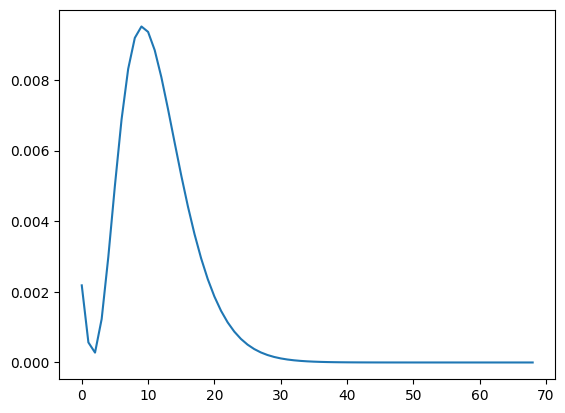

In [115]:
plt.plot(r_expect)

## Exactly solved version

### Radial Grid

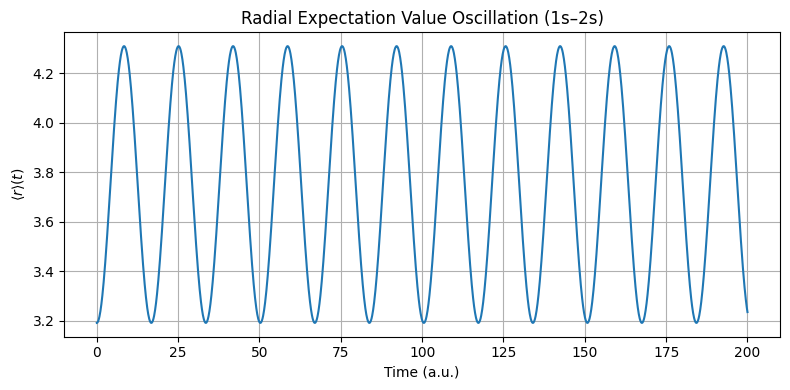

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Energies (atomic units)
# -------------------------
E1 = -0.5
E2 = -0.125
omega = E2 - E1

# -------------------------
# Radial grid
# -------------------------
r = np.linspace(0, 40, 4000)
dr = r[1] - r[0]

# -------------------------
# Hydrogen wavefunctions
# -------------------------
psi_1s = (1 / np.sqrt(np.pi)) * np.exp(-r)
psi_2s = (1 / (4 * np.sqrt(2 * np.pi))) * (2 - r) * np.exp(-r / 2)

# -------------------------
# Time-dependent wavefunction
# -------------------------
def psi_t(t):
    return (psi_1s * np.exp(-1j * E1 * t)
          + psi_2s * np.exp(-1j * E2 * t)) / np.sqrt(2)

# -------------------------
# Time grid
# -------------------------
t = np.linspace(0, 200, 2000)

# -------------------------
# Compute <r>(t)
# -------------------------
r_expect = []

for ti in t:
    psi = psi_t(ti)
    density = np.abs(psi)**2
    r_exp = np.sum(density * r * 4*np.pi*r**2) * dr
    r_expect.append(r_exp)

r_expect = np.array(r_expect)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(8, 4))
plt.plot(t, r_expect)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle r \rangle(t)$")
plt.title("Radial Expectation Value Oscillation (1s–2s)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Metropolis sampling and autodiff energy gradients

In [22]:
from local_energy import get_local_energy_fn

In [21]:
def f(params, x):
    r = jnp.linalg.norm(x)
    psi = (
        (1 / jnp.sqrt(jnp.pi)) * jnp.exp(-r)
        + (1 / (4 * jnp.sqrt(2 * jnp.pi))) * (2 - r) * jnp.exp(-r / 2)
    ) / jnp.sqrt(2)
    return psi

In [23]:
f_b = jax.vmap(f, in_axes=(None, 0))

loc_energy = get_local_energy_fn(f, 1, 1)

In [24]:
le = loc_energy(params, pos)

In [25]:
jnp.mean(loc_energy(params, pos))

Array(-0.40925688+0.j, dtype=complex64)

In [26]:
## Warmup steps
pos = jax.random.uniform(key, (4200, 3))

for i in range(10):
    pos, pmove = metropolis_step(params, f_b, pos, key, 0.5)
print(pmove)

0.576619


In [60]:
le = loc_energy(params, pos)

In [61]:
jnp.mean(le)

Array(-0.39638376+0.j, dtype=complex64)

In [63]:
jnp.mean(le - jnp.mean(le))

Array(1.2800807e-08+0.j, dtype=complex64)

In [64]:
jnp.mean((le - jnp.mean(le)) ** 2)

Array(0.04612977+0.j, dtype=complex64)

In [19]:
E1 = -0.5
E2 = -0.125

def psi_t(params, x, t):
    r = jnp.linalg.norm(x)

    psi_1s = (1 / jnp.sqrt(jnp.pi)) * jnp.exp(-r)
    psi_2s = (1 / (4 * jnp.sqrt(2 * jnp.pi))) * (2 - r) * jnp.exp(-r / 2)

    return (
        psi_1s
        + psi_2s * jnp.exp(-1j * (E2-E1) * t)
    ) / jnp.sqrt(2)

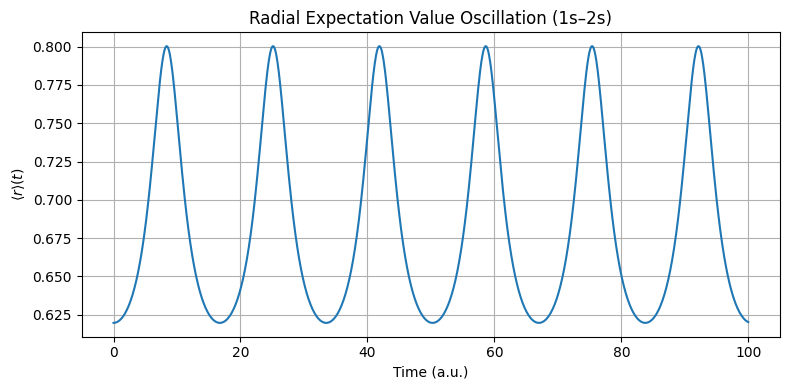

In [ ]:
#def psi_t(params, x, t):
#    return f(params, x) * jnp.exp(-1j * (E2 - E1) * t)

psi_b = jax.vmap(psi_t, in_axes=(None, 0, None))

# -------------------------
# Time grid
# -------------------------
t = jnp.linspace(0, 10.0, 1000)

# -------------------------
# Compute <r>(t)
# -------------------------
r_expect = []

for ti in t:
    psi = psi_b(params, pos, ti)
    density = jnp.abs(psi) ** 2
    r = jnp.linalg.norm(pos, axis=1)

    r_expect_t = jnp.sum(density * r) / jnp.sum(density)
    r_expect.append(r_expect_t)

r_expect = jnp.array(r_expect)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(8, 4))
plt.plot(t, r_expect)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle r \rangle(t)$")
plt.title("Radial Expectation Value Oscillation (1s–2s)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Frequency extraction

In [24]:
import numpy as np

signal = r_expect - jnp.mean(r_expect)
dt = t[1] - t[0]

fft_vals = np.fft.rfft(signal)
freqs = np.fft.rfftfreq(len(signal), dt)

power = np.abs(fft_vals) ** 2

idx = np.argmax(power[1:]) + 1   # skip zero frequency
f_peak = freqs[idx]

omega_peak = 2 * np.pi * f_peak
print("Extracted ω:", omega_peak)


Extracted ω: 0.37661415


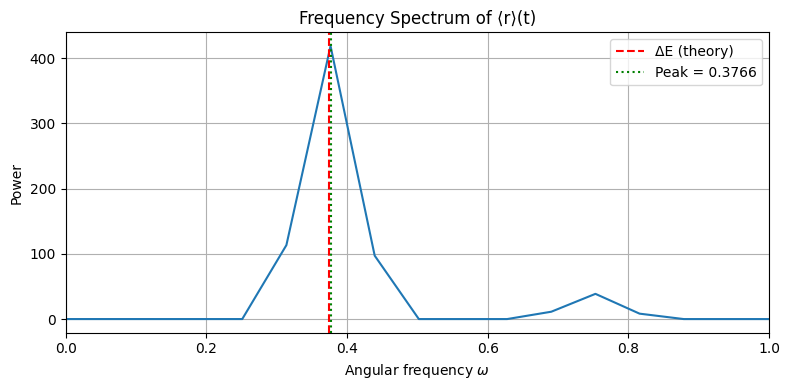

In [25]:
dt = t[1] - t[0]

signal = r_expect - np.mean(r_expect)
window = np.hanning(len(signal))

fft_vals = np.fft.rfft(signal * window)
freqs = np.fft.rfftfreq(len(signal), dt)

power = np.abs(fft_vals) ** 2
omega = 2 * np.pi * freqs

plt.figure(figsize=(8, 4))
plt.plot(omega, power)
plt.axvline(0.375, color="red", linestyle="--", label="ΔE (theory)")
plt.axvline(omega[np.argmax(power[1:]) + 1],
            color="green", linestyle=":",
            label=f"Peak = {omega[np.argmax(power[1:]) + 1]:.4f}")

plt.xlim(0, 1.0)
plt.xlabel(r"Angular frequency $\omega$")
plt.ylabel("Power")
plt.title("Frequency Spectrum of ⟨r⟩(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
